# 심층 신경망 훈련하기

------

고해상도 이미지 등 복잡한 문제를 다룰 때 매우 깊은 심층 신경망을 훈련해야 할 수 있다.

심층 신경망 훈련 도중 다음과 같은 상황을 마주할 수 있다.

* 까다로운 그레디언트 소실 또는 그레디언트 폭주 문제에 직면할 수 있음. 심층 신경망 아래쪽으로 갈수록 그레디언트가 점점 작아지거나 커지는 현상

* 대규모 신경망을 훈련하기 위한 데이터가 충분치 않거나 레이블을 만드는데 비용이 많이 듬

* 훈련이 극단적으로 느려짐

* 수백만개의 파라미터를 가진 모델은 과적합될 수 있음

## 그레디언트 소실, 폭주 문제

-----

역전파 알고리즘이 하위층(입력층 근처)으로 진행될수록 그레디언트가 작아지거나 (소실) 커지는 현상 (폭주)은 훈련을 어렵게 한다.

의심되는 원인으로서 많이 사용되는 로지스틱 시그모이드 활성화 함수와, 표준정규분포 가중치 초기화 방법이 거론된다.

로지스틱 함수는 입력이 양수나 음수로 커지면 기울기가 0에 매우 가까워진다.

역전파가 될 때, 전달될 그레디언트가 거의 없고, 조금 있는 그레디언트는 최상위층으로부터 진행되며 점점 약해진다.

### 가중치 초기화 방법

이전에 살펴봤듯이 모델을 생성할 때 가중치는 랜덤으로 초기화된다.

로지스틱 함수를 이용할 때, 각 층의 연결 가중치를 아래의 식을 이용하여 랜덤 초기화하면 그레디언트 문제를 완화할 수 있다.

이를 Xavier initialization라고 한다.

$$ \text{정규분포 : 평균이 0이고, 표준편차 } \sigma = \sqrt{\frac{1}{\text{fan}_{\mathrm{avg}}}} $$
$$ \text{혹은, 균등분포 : between } -r \text{ and } r, \text{ with } r = \sqrt{\frac{3}{\text{fan}_{\mathrm{avg}}}} $$

여기서 $\text{fan}_{\mathrm{avg}}$은 층의 입력과 출력의 연결 개수인 $\text{fan}_{\mathrm{in}}$과 $\text{fan}_{\mathrm{out}}$의 평균이다.

그 외에 다음과 같은 [초기화 전략](https://keras.io/api/layers/initializers/)들이 있다.
  
| 초기화 전략 | 활성화 함수 | 정규분포 분산 |
|--|--|--|
| Glorot | 활성화 함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스 | $1/\text{fan}_{\mathrm{avg}}$ |
| He | ReLu 함수와 그 변종들 | $2 / \text{fan}_{\mathrm{in}}$ |
| LuCun | SELU | $1/\text{fan}_{\mathrm{in}}$ |

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다. 

다음과 같이 층을 만들 때, ```kernerl_initializer="he_uniform"```로 바꾸어 쓸 수 있다. 

``` keras.layer.Dense(10, activation="relu", kernel_initializer="he_normal")```

한편, `keras.layer.Dense`의 기본값은 `kernel_initializer="glorot_uniform"`이다.

### 활성화 함수 문제

활성화 함수를 잘못 선택하면 그레디언트 소실이나 폭주로 이어질 수 있다.

초기에는 생물학적 뉴런과 비슷한 시그모이드 함수가 잘 작동할 것이라고 생각되었지만, ReLu 같은 활성화 함수가 심층 신경망에서 더 잘 작동하는 경향이 있다.

하지만 ReLu도 완벽하지 않고, 죽은 ReLu 문제가 알려져 있다.

훈련 중 일부 뉴런이 0만 출력하는 현상이다.

이 문제를 해결하기 위해 LeakyReLu, ELU, SELU 같은 변종을 사용한다.

$$ \mathrm{LeakyReLu}_{\alpha}(z) = \max(\alpha z, z) $$

$$ \mathrm{ELU}_{\alpha}(z) = 
\left\{ \begin{array}{ll} \alpha (\exp(z) - 1) & z < 0 \\
z & z \geq 0 \end{array} \right.
$$

$$ \mathrm{SELU}_{\alpha}(z) =
\left\{ \begin{array}{ll}
\lambda \alpha (\exp(z) - 1) & \text{if } z < 0 \\
\lambda z & \text{if } z \geq 0 \\
\end{array}
\right.
$$

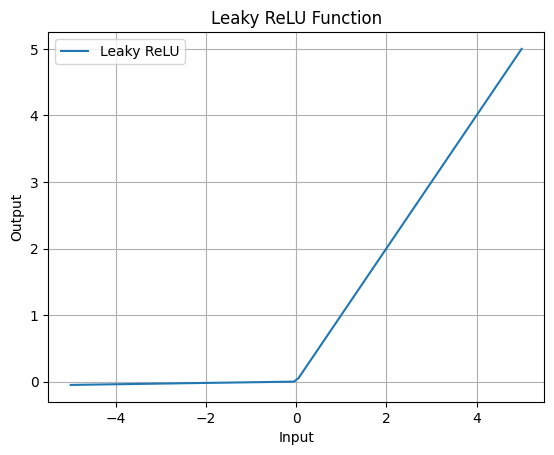

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

x_values = np.linspace(-5, 5, 100)
y_values = leaky_relu(x_values)

plt.plot(x_values, y_values, label='Leaky ReLU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Leaky ReLU Function')
plt.legend()
plt.grid(True)
plt.show()

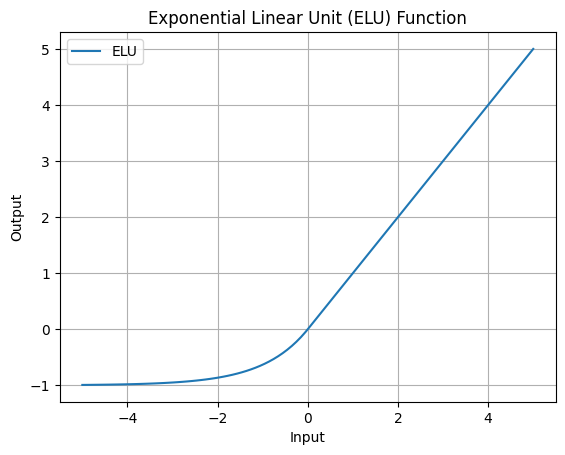

In [2]:
def elu(x, alpha=1.0):
    return np.where(x < 0, alpha * (np.exp(x) - 1), x)

x_values = np.linspace(-5, 5, 100)
y_values = elu(x_values)

plt.plot(x_values, y_values, label='ELU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Exponential Linear Unit (ELU) Function')
plt.legend()
plt.grid(True)
plt.show()

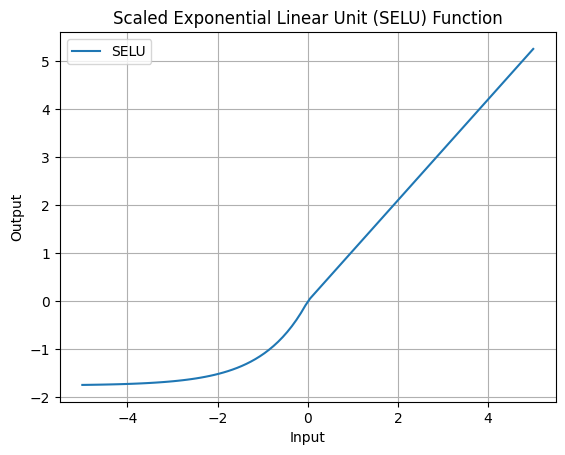

In [3]:
def selu(x, alpha=1.67326, scale=1.0507):
    return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

x_values = np.linspace(-5, 5, 100)
y_values = selu(x_values)

# 그래프 그리기
plt.plot(x_values, y_values, label='SELU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Scaled Exponential Linear Unit (SELU) Function')
plt.legend()
plt.grid(True)
plt.show()

케라스에서 [LeakyReLu](https://keras.io/api/layers/activation_layers/leaky_relu/)를 사용하려면 다음과 같이 코드를 작성한다. 즉, Dense 층의 뒤에 LeakyReLU 층을 추가한다.

```
model = keras.models.Sequential([
  [...]
  keras.layers.Dense(10, kernel_initializer="he_normal"),
  keras.layers.LeakyReLU(alpha=0.2)
  [...]
])
```

SELU 함수를 사용하려면 다음과 같이 코드를 작성한다.

``` lyaer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal") ```

`keras.datasets.fashion_mnist`를 이용하여 예제를 실행해 본다.

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [7]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2246 - accuracy: 0.6330 - val_loss: 0.8507 - val_accuracy: 0.7328
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7728 - accuracy: 0.7499 - val_loss: 0.6994 - val_accuracy: 0.7772
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6705 - accuracy: 0.7813 - val_loss: 0.6299 - val_accuracy: 0.8002
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6134 - accuracy: 0.7976 - val_loss: 0.5834 - val_accuracy: 0.8116
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5765 - accuracy: 0.8083 - val_loss: 0.5527 - val_accuracy: 0.8216
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5503 - accuracy: 0.8157 - val_loss: 0.5302 - val_accuracy: 0.8266
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5303 - accuracy: 0.8206 - val_loss: 0.5142 - val_accur

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [11]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 1.3537 - accuracy: 0.5893 - val_loss: 0.9112 - val_accuracy: 0.7218
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8094 - accuracy: 0.7476 - val_loss: 0.7144 - val_accuracy: 0.7760
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6830 - accuracy: 0.7829 - val_loss: 0.6369 - val_accuracy: 0.7932
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6203 - accuracy: 0.7991 - val_loss: 0.5862 - val_accuracy: 0.8094
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5804 - accuracy: 0.8091 - val_loss: 0.5513 - val_accuracy: 0.8186
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5528 - accuracy: 0.8167 - val_loss: 0.5279 - val_accuracy: 0.8280
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5319 - accuracy: 0.8227 - val_loss: 0.5121 - val_accu

### 배치 정규화

각 층에서 활성화 함수를 통과하기 전이나 후에 정규화 연산을 추가한다.

이 연산은 단순히 입력을 원점에 맞추어 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값을 스케일링하고 이동시킨다.


과정의 순서는 다음과 같다.

* 미니배치별로 배치정규화층에 사용될 입력값의 표본평균과 표본표준편차를 계산한다.

* 평균과 표준편차를 이용하여 입력값을 정규화한다. 

   * 하지만 정규화된 값들은 평균 0과 표준편차 1의 분포를 가지는데 이러한 제약은 뉴럴 네트워크의 성능을 제한할 수 있다.

* 이에 훈련 가능한 스케일 파라미터 $\mathbf{\gamma}$와 오프셋 파라미터 $\mathbf{\beta}$를 추가 도입하여 네트워크의 성능을 향상하도록 한다.

$$ \mathbf{\gamma} \circ \mathbf{\hat x} + \mathbf{\beta} $$

* 여기서 $\mathbf{\hat x}$은 정규화된 입력값이다.

얼핏 보기에는 표준 정규화 후에 다시 $\mathbf{\gamma}$와 $\mathbf{\beta}$로 rescaling하는 과정이 의미가 없어 보일 수 있다.

하지만 입력값들의 훈련에 적합한 최적 평균 $\mathbf{\beta}$과 최적 표준편차 $\mathbf{\gamma}$를 찾는 과정이라고 생각하면 좋다.

이 과정을 복잡한 네트워크 구조가 아닌 $\mathbf{\gamma}$와 $\mathbf{\beta}$만으로 훈련하여 익히게 하면 좋은 성능 향상을 기대할 수 있다고 한다.

한편 테스트 셋에서의 정규화는 배치 별로 진행할 수 없으므로, 훈련 데이터에서 배치 별로 계산한 평균과 표준편차를 평균내어 사용한다.

배치정규화는 신경망의 성능을 크게 향상시킨다고 알려져 있다.

케라스에서는 [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/)을 이용하여 배치 정규화를 구현한다.

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

In [14]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.8329 - accuracy: 0.7227 - val_loss: 0.5430 - val_accuracy: 0.8182
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5686 - accuracy: 0.8035 - val_loss: 0.4711 - val_accuracy: 0.8418
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5109 - accuracy: 0.8222 - val_loss: 0.4377 - val_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4780 - accuracy: 0.8346 - val_loss: 0.4147 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4527 - accuracy: 0.8417 - val_loss: 0.3993 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4335 - accuracy: 0.8478 - val_loss: 0.3900 - val_accuracy: 0.8656
Epoch 7/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4205 - accuracy: 0.8521 - val_loss: 0.3827 - val_ac

In [17]:
#### 활성화 함수 전에 사용하는 방법


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 1.0287 - accuracy: 0.6761 - val_loss: 0.6754 - val_accuracy: 0.7798
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6734 - accuracy: 0.7823 - val_loss: 0.5578 - val_accuracy: 0.8148
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5909 - accuracy: 0.8033 - val_loss: 0.5015 - val_accuracy: 0.8300
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5444 - accuracy: 0.8167 - val_loss: 0.4683 - val_accuracy: 0.8402
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5095 - accuracy: 0.8264 - val_loss: 0.4467 - val_accuracy: 0.8450
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4893 - accuracy: 0.8313 - val_loss: 0.4300 - val_accuracy: 0.8518
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4713 - accuracy: 0.8383 - val_loss: 0.4159 - val_ac

### 그레이디언트 클리핑

그레디언트 폭주 문제를 완화하는 방법으로 역전파 수행 시 그레디언트가 일정 임계값을 넘지 못하도록 하는 것이다.

이 작업은 optimzier를 설정할 때 이루어진다.

```optimizer = keras.optimizers.SGD(clipvalue=1.0)```

```optimizer = keras.optimizers.SGD(clipnorm=1.0)```

## 훈련된 층 재사용 하기
-----

아주 큰 DNN을 처음부터 훈련하는 것인 시간이 오래 걸리기 때문에 비슷한 유형의 문제를 처리한 신경망의 하위층을 재사용할 수 있다.

(상위 층은 덜 유용함)

이를 전이 학습 (transfer learning)이라 한다.

먼저 재사용 층의 가중치들을 동결한다.

그 다음 모델을 학습하고 평가한다.

맨 위 한 두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인한다.

### 케라스를 이용한 전이 학습

패션 MNIST 훈련 세트를 두 개로 나눈다.

* X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트


A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보자. 

A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷함. 

In [20]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [21]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [22]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [23]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 10s 7ms/step - loss: 0.5613 - accuracy: 0.8173 - val_loss: 0.3848 - val_accuracy: 0.8660
Epoch 2/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.3600 - accuracy: 0.8745 - val_loss: 0.3242 - val_accuracy: 0.8886
Epoch 3/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.3209 - accuracy: 0.8884 - val_loss: 0.3014 - val_accuracy: 0.8951
Epoch 4/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.3009 - accuracy: 0.8952 - val_loss: 0.2895 - val_accuracy: 0.9001
Epoch 5/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2868 - accuracy: 0.9017 - val_loss: 0.2790 - val_accuracy: 0.9036
Epoch 6/20
1375/1375 [==============================] - 9s 7ms/step - loss: 0.2774 - accuracy: 0.9046 - val_loss: 0.2700 - val_accuracy: 0.9043
Epoch 7/20
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2694 - accuracy: 0.9082 - val_loss: 0.2617 - val_accuracy

In [24]:
model_A.save("my_model_A.keras")

model B는 자체 훈련으로 생성

In [25]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [26]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [27]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 70ms/step - loss: 0.6598 - accuracy: 0.6050 - val_loss: 0.5394 - val_accuracy: 0.7850
Epoch 2/20
7/7 [==============================] - 0s 25ms/step - loss: 0.4917 - accuracy: 0.8150 - val_loss: 0.4404 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 26ms/step - loss: 0.4007 - accuracy: 0.8700 - val_loss: 0.3746 - val_accuracy: 0.8824
Epoch 4/20
7/7 [==============================] - 0s 23ms/step - loss: 0.3373 - accuracy: 0.9050 - val_loss: 0.3257 - val_accuracy: 0.9138
Epoch 5/20
7/7 [==============================] - 0s 23ms/step - loss: 0.2899 - accuracy: 0.9400 - val_loss: 0.2862 - val_accuracy: 0.9290
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.2517 - accuracy: 0.9600 - val_loss: 0.2559 - val_accuracy: 0.9381
Epoch 7/20
7/7 [==============================] - 0s 25ms/step - loss: 0.2220 - accuracy: 0.9700 - val_loss: 0.2327 - val_accuracy: 0.9452
Epoch 8/20
7/7 [===========

In [28]:
model_B.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 300)               235500    
                                                                 
 dense_19 (Dense)            (None, 100)               30100     
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 1)                

model_A와 model_B_on_A는 일부 층을 공유한다.

In [29]:
model_A = keras.models.load_model("my_model_A.keras")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

model_B_on_A를 훈련할 때 model_A도 영향을 받는다. 이를 원치 않으면 ```clone_model()``` 메쏘드로 구조를 복제한 뒤 가중치를 복사해둔다.

In [30]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

이제 model_B_on_A를 훈련할 수 있는데, 새로운 출력층이 랜덤하게 초기화되었으므로, 큰 오차를 생성할 수 있음.

큰 오차 그레디언트가 재사용된 가중치를 망치지 않도록, 처음 몇 번의 에포크 동안은 재사용된 층을 동결하고 새로운 층에 적절한 가중치를 학습할 시간을 준다.

In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

모델을 몇번 훈련하고, 재사용된 층의 동결을 해제한 뒤, 다시 컴파일한 다음, 훈련을 계속한다.

일반적으로 재사용된 층의 동결을 해제한 후 학습률을 낮추는 것이 좋다.

In [32]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 66ms/step - loss: 1.4171 - accuracy: 0.1800 - val_loss: 1.3435 - val_accuracy: 0.2150
Epoch 2/4
7/7 [==============================] - 0s 22ms/step - loss: 1.2915 - accuracy: 0.2300 - val_loss: 1.2274 - val_accuracy: 0.2566
Epoch 3/4
7/7 [==============================] - 0s 22ms/step - loss: 1.1760 - accuracy: 0.2800 - val_loss: 1.1293 - val_accuracy: 0.3134
Epoch 4/4
7/7 [==============================] - 0s 24ms/step - loss: 1.0786 - accuracy: 0.3400 - val_loss: 1.0387 - val_accuracy: 0.3682
Epoch 1/16
7/7 [==============================] - 1s 71ms/step - loss: 0.8355 - accuracy: 0.5100 - val_loss: 0.6384 - val_accuracy: 0.6247
Epoch 2/16
7/7 [==============================] - 0s 25ms/step - loss: 0.5254 - accuracy: 0.7250 - val_loss: 0.4395 - val_accuracy: 0.7992
Epoch 3/16
7/7 [==============================] - 0s 27ms/step - loss: 0.3645 - accuracy: 0.8800 - val_loss: 0.3330 - val_accuracy: 0.8824
Epoch 4/16
7/7 [===============

In [33]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.1115 - accuracy: 0.9780


[0.11146294325590134, 0.9779999852180481]

In [34]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0871 - accuracy: 0.9855


[0.08706396818161011, 0.9854999780654907]

## 고속 옵티마이저
-----

아주 큰 심층 신경망의 훈련 속도는 심각하게 느릴 수 있다.  

표준적인 경사 하강법 외에 속도 향상을 위해 특별하게 구현된 옵티마이저들을 이용할 수 있다.  

이러한 옵티마이저들에 대해 자세히 다루지는 않겠지만 대략 어떤 종류의 것들이 있는지 살펴본다.

#### 모멘텀 옵티마이저

일반적인 경사 하강법은 그레디언트가 작으면 천천히 수렴한다.  

모멘텀 옵타마이저는 그레디언트가 작을 경우 높은 학습률을, 그레디언트가 클 경우 상대적으로 작은 학습률을 부여한다.

보통 ```momentum=0.9``` 정도로 설정하면 잘 작동한다고 한다.

In [35]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

#### 네스테로프 가속 경사

모멘텀 옵티마이저를 더 향상시킨 방법이다.

In [36]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

#### AdaGrad

AdaGrad는 경사 하강법의 최적화 알고리즘 중 하나로 각 parameter들에 대해 학습률을 조정하여 성능을 향상시킨다.

일반적으로 gradient가 큰 parameter는 작은 학습률을, gradient가 작은 parameter는 큰 학습률을 적용한다.

[`keras.optimizers.Adagrad`](https://keras.io/api/optimizers/adagrad/)를 이용한다.

In [37]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

#### RMSProp

AdaGrad는 학습률이 너무 빨리 줄어들어 전역 최적점에 수렴하지 못하는 경우가 있기 때문에 이를 개선한 방법이다.

RMSProp는 Root Mean Squared Propagation을 뜻한다.

[`keras.optimizers.RMSprop`](https://keras.io/api/optimizers/rmsprop/)를 이용한다.

In [38]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

#### Adam 옵티마이저

Adam은 adaptive moment estimation을 뜻하며 모멘텀 최적화와 RMSProp을 합친 개념이다.

많은 신경망 학습에서 효과적으로 사용된다고 알려져 있으며, 다양한 하이퍼파라미터 설정에 덜 민감하다고 한다.

[`keras.optimizers.Adam`](https://keras.io/api/optimizers/adam/)을 이용한다.

In [39]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Adamax 옵티마이저

Adam의 변종으로 만약 Adam이 잘 작동하지 않는다면 시도해 볼만한 옵티마이저이다.

In [40]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam 옵티마이저

마찬가지로 Adam의 변종으로 종종 Adam보다 조금 더 빠르게 수렴한다고 알려져 있다.

In [41]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 학습률 스케쥴링
----

학습률을 너무 크게 잡으면 훈련이 발산할 수 있고, 너무 작게 잡으면 수렴 시간이 오래 걸릴 것이다.

큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추는 전략을 취할 수 있다.

훈련하는 동안 학습률을 감소시키는 학습 스케쥴에는 여러가지가 있다.

### 거듭제곱 기반 스케쥴링

반복횟수 $t$에 대해 학습률을 다음과 같이 정의한다.

$$\eta(t) = \frac{\eta_0}{(1 + t / s)^c}$$

케라스에서 학습률을 동적으로 조절하기 위해서는 [`keras.callbacks.LearningRateScheduler`](https://keras.io/api/callbacks/learning_rate_scheduler/)를 이용한다.

In [42]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [43]:
def power_schedule(t, initial_lr = 0.01, decay_rate = 0.001, power = 1):
    return initial_lr / ((1 + decay_rate * t) ** power)

lr_scheduler = keras.callbacks.LearningRateScheduler(power_schedule)

In [44]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",optimizer = keras.optimizers.SGD(learning_rate=0.01), metrics=["accuracy"])

In [45]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid), 
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4878 - accuracy: 0.8281 - val_loss: 0.4125 - val_accuracy: 0.8532 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3783 - accuracy: 0.8662 - val_loss: 0.3742 - val_accuracy: 0.8682 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3435 - accuracy: 0.8773 - val_loss: 0.3490 - val_accuracy: 0.8824 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3198 - accuracy: 0.8854 - val_loss: 0.3523 - val_accuracy: 0.8750 - lr: 0.0099
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3024 - accuracy: 0.8913 - val_loss: 0.3348 - val_accuracy: 0.8814 - lr: 0.0099
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2865 - accuracy: 0.8972 - val_loss: 0.3286 - val_accuracy: 0.8856 - lr: 0.0099
Epoch 7/25
1719/1719 [==============================] - 8s

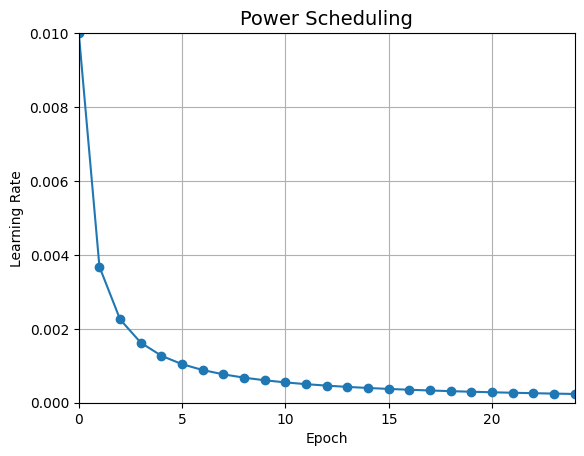

In [46]:
import math
import matplotlib.pyplot as plt

batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)

lrs = power_schedule(epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케쥴링

비슷하게 지수 기반으로 감소하는 학습률 스케쥴링을 사용할 수 있다.

```lr = lr0 * 0.1**(epoch / s)```

In [47]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [48]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [49]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.7428 - accuracy: 0.7777 - val_loss: 0.6111 - val_accuracy: 0.8032 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6200 - accuracy: 0.8077 - val_loss: 0.6699 - val_accuracy: 0.8110 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6151 - accuracy: 0.8152 - val_loss: 0.6930 - val_accuracy: 0.8150 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5381 - accuracy: 0.8351 - val_loss: 0.5802 - val_accuracy: 0.8474 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5154 - accuracy: 0.8412 - val_loss: 0.5477 - val_accuracy: 0.8348 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4634 - accuracy: 0.8537 - val_loss: 0.4772 - val_accuracy: 0.8516 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

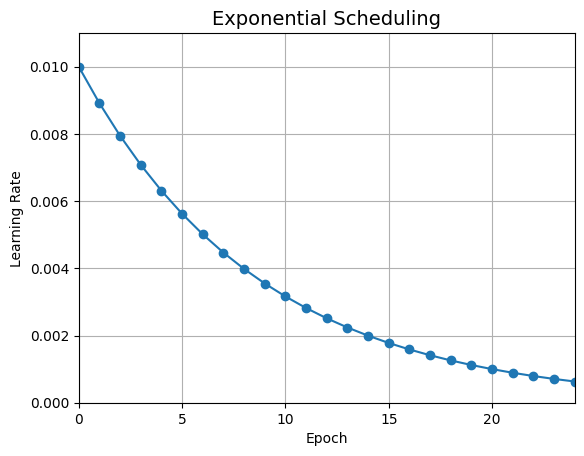

In [50]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

그 외에

* 구간별 고정 스케쥴링
* 성능 기반 스케쥴링
* 1 사이클 스케쥴링

## 과대적합 피하기
-----

### $\ell_1$과 $\ell_2$ 규제

선형 모델에서 했던 것처럼 신경망의 연결 가중치를 제한하기 위해  $\ell_2$ 규제를 사용하거나, 아예 일부 가중치를 0으로 만들기 위해  $\ell_1$ 규제를 적용할 수 있다.

In [51]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [52]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 1.5935 - accuracy: 0.8134 - val_loss: 0.7343 - val_accuracy: 0.8232
Epoch 2/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7207 - accuracy: 0.8245 - val_loss: 0.7013 - val_accuracy: 0.8364


### 드롭아웃

드롭아웃은 심층 신경망에서 인기 있는 규제로 잘 작동된다고 입증되었다.

매 훈련 각 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 $p$를 가진다.

* 드롭아웃 비율은 보통 10-50% 사이를 지정한다.
* 순환 신경망에서는 20-30%에 가깝고, 합성곱 신경망에서는 40-50%에 가깝다.

즉, 이번 훈련에는 무시되어도 다음 훈련에서는 활성화 될 수 있다.

훈련이 끝난 후에는 드랍아웃을 적용하지 않는다.

각 훈련에서 고유한 네트워크가 생성되는 것처럼 간주할 수 있다.

케라스에서는 [```keras.layers.Dropout```](https://keras.io/api/layers/regularization_layers/dropout/)을 이용해 구현한다.

`tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, **kwargs)`

이 층은 훈련하는 동안 일부 입력을 랜덤하게 버린다 (0으로 설정).

그 다음 남은 입력을 $1-p$로 나눈다.

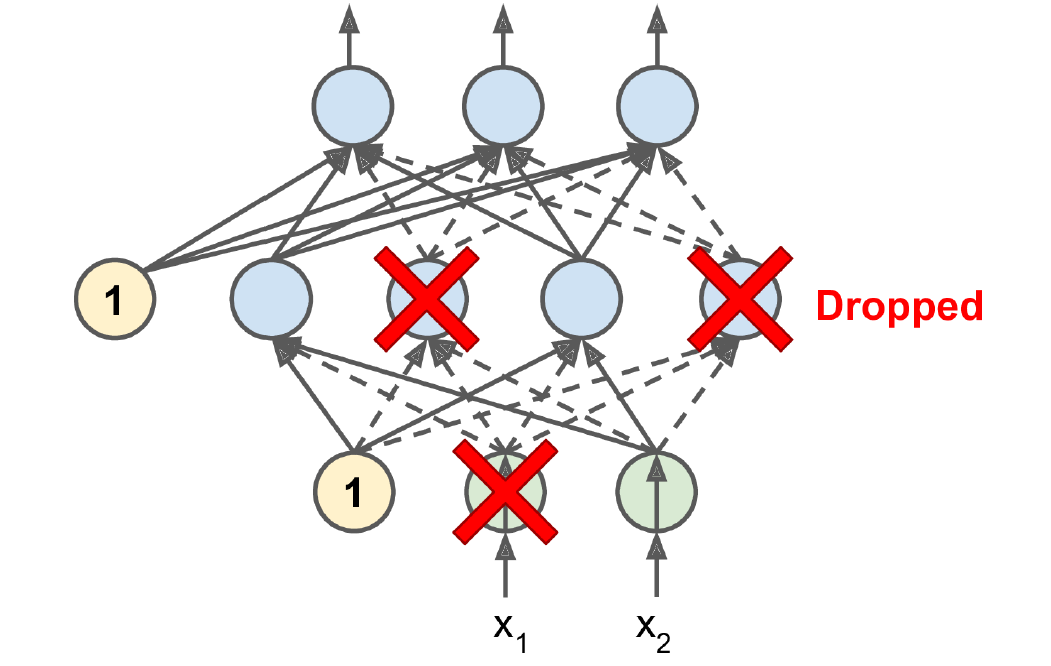

In [53]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 0.5699 - accuracy: 0.8020 - val_loss: 0.3648 - val_accuracy: 0.8652
Epoch 2/2
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4245 - accuracy: 0.8429 - val_loss: 0.3681 - val_accuracy: 0.8678


간단하게 더 살펴보자.

Dropout layer에 ```training=True```로 설정하여 값을 통과시키면 랜덤하게 일부가 0으로 설정되는 것을 볼 수 있다.

In [54]:
dropmodel = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(None, 5), activation="relu"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(3, activation="softmax")
])

In [55]:
output1 = dropmodel.layers[0](np.array([[1, 2, 3, 4, 5]]))
print(output1)

tf.Tensor(
[[0.        0.        2.2444994 3.999331  0.        4.1119933 0.
  0.        0.        1.0440902]], shape=(1, 10), dtype=float32)


In [56]:
output2 = dropmodel.layers[1](output1, training=True)
print(output2)

tf.Tensor(
[[0.       0.       4.488999 7.998662 0.       0.       0.       0.
  0.       0.      ]], shape=(1, 10), dtype=float32)


훈련이 아닐 경우에는 입력이 출력으로 그대로 전달된다.

In [57]:
print(dropmodel.layers[1](output1))

tf.Tensor(
[[0.        0.        2.2444994 3.999331  0.        4.1119933 0.
  0.        0.        1.0440902]], shape=(1, 10), dtype=float32)


모델이 과대적합 되었다면 드롭아웃 비율을 늘릴 수 있다.  
반대로 모델이 과소적합 되었다면 드롭아웃 비율을 낮추어야 한다.  
층이 클 때는 드롭아웃 비율을 늘리고 작은 층에는 드롭아웃 비율을 낮추는 것도 도움이 된다.  
또한 많은 최신의 신경망 구조는 마지막 은닉층에만 드롭아웃을 사용하기도 한다.